**Task 1:** Image classification using a MLFFNN with two hidden layers, and with Deep CNN
features for an image as the input to the MLFFNN, with (a) VGGNet as Deep CNN and (b)
GoogLeNet as Deep CNN.

In [ ]:
# **Task 1:** Image classification using a MLFFNN with two hidden layers, and with Deep CNN
# features for an image as the input to the MLFFNN, with (a) VGGNet as Deep CNN and (b)
# GoogLeNet as Deep CNN.

In [ ]:
# You can Pytorch
# dataset is in ./dataset/classification
# ./dataset/classification/train/ contains 5 folders, with 100 images in each
# ./dataset/classification/test/ contains 5 folders, with 100 images in each
# ./dataset/classification/valid/ contains 5 folders, with 100 images in each


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


In [13]:
os.makedirs('plots/Q1', exist_ok=True)
os.makedirs('models', exist_ok=True)

In [4]:
# Customize matplotlib parameters
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['font.family'] = 'serif'
plt.rcParams['savefig.format'] = 'pdf'
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['axes.linewidth'] = 3


In [5]:
import zipfile

# Replace 'file_name.zip' with the name of your zip file
zip_file_path = '/content/gdrive/MyDrive/Colab Notebooks/classification.zip'

extract_to_path = '/content/dataset/'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

In [6]:
# Load dataset

# Normalize the image data to have mean 0 and standard deviation 1
# Resize the image to 224x224
# Convert the image to tensor
# Create a DataLoader for the dataset
# Use a batch size of 32
# Shuffle the dataset

data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(root='./dataset/classification/train', transform=data_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataset = datasets.ImageFolder(root='./dataset/classification/valid', transform=data_transform)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)
test_dataset = datasets.ImageFolder(root='./dataset/classification/test', transform=data_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [7]:
len(train_dataset.classes)

5

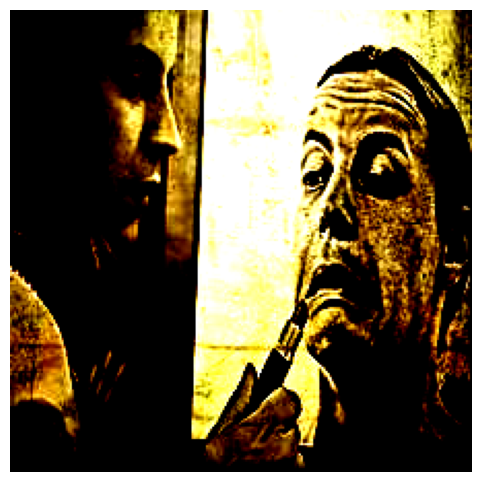

In [8]:
plt.imshow(train_loader.dataset[1000][0].permute(1, 2, 0))
plt.axis('off')
plt.show()

## Image Classification using MLFFNN

In [32]:
class ImageClassification:
    def __init__(self, model, criterion, optimizer, deep_cnn='vgg'):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.deep_cnn = deep_cnn
        self.train_losses = []
        self.train_accuracies = []
        self.valid_losses = []
        self.valid_accuracies = []

        if os.path.exists('models/Q1_{self.deep_cnn}.pt'):
            checkpoint = torch.load(f'models/Q1_{self.deep_cnn}.pt', map_location=device)
            self.model.load_state_dict(checkpoint['model'])
            self.optimizer.load_state_dict(checkpoint['optimizer'])
            self.train_losses = checkpoint['losses']['train']
            self.train_accuracies = checkpoint['accuracies']['train']
            self.valid_losses = checkpoint['losses']['valid']
            self.valid_accuracies = checkpoint['accuracies']['valid']

        self.start_epoch = len(self.train_losses)

    def train(self, train_loader, valid_loader, num_epochs=5):
        for epoch in range(self.start_epoch, num_epochs):
            tqdm_train_loader = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            for i, (images, labels) in enumerate(tqdm_train_loader):
                images, labels = images.to(device), labels.to(device)
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()
                predicted = torch.argmax(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                tqdm_train_loader.set_postfix({'Running Loss': running_loss / (i + 1)})
                tqdm_train_loader.set_description(f"Epoch {epoch+1}/{num_epochs}")

            train_loss = running_loss / len(train_loader)
            train_accuracy = correct / total
            valid_loss, val_accuracy = self.evaluate(valid_loader)
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_accuracy)
            self.valid_losses.append(valid_loss)
            self.valid_accuracies.append(val_accuracy)
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
            print(f'Epoch {epoch+1}/{num_epochs}, Valid Loss: {valid_loss:.4f}, Valid Accuracy: {val_accuracy:.4f}')
            # save checkpoint.
            torch.save({
                'model': self.model.state_dict(),
                'optimizer': self.optimizer.state_dict(),
                'losses': {'train': self.train_losses, 'valid': self.valid_losses},
                'accuracies': {'train': self.train_accuracies, 'valid': self.valid_accuracies}
            }, f'models/Q1_{self.deep_cnn}.pt')

            if train_loss < 0.001:
                break

    def evaluate(self, valid_loader):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_accuracy = correct / total
        valid_loss = running_loss / len(valid_loader)
        return valid_loss, val_accuracy

    def test(self, test_loader):
        test_loss, test_accuracy = self.evaluate(test_loader)
        print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

    def plot_cm_train(self, train_loader):
        self.model.eval()
        y_true = []
        y_pred = []
        with torch.no_grad():
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs, 1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())
        cm = confusion_matrix(y_true, y_pred)
        cm_norm = cm / cm.sum(axis=1)[:, np.newaxis]
        plt.figure(figsize=(12, 9))
        annot_labels = np.array([[f'{norm*100:.2f}%\n({count})' for norm, count in zip(row, cm_row)] for row, cm_row in zip(cm_norm, cm)])
        sns.heatmap(cm, annot=annot_labels, fmt='', xticklabels=train_loader.dataset.classes, yticklabels=train_loader.dataset.classes, cmap='YlGnBu', annot_kws={'fontsize': 14})
        plt.xlabel('Predicted')
        plt.ylabel('True')
        # plt.title('Confusion Matrix (Train)')
        plt.axis('equal')
        plt.savefig(f'plots/Q1/confusion_matrix_train_{self.deep_cnn}.pdf')
        plt.show()

    def plot_cm_test(self, test_loader):
        self.model.eval()
        y_true = []
        y_pred = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs, 1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())
        cm = confusion_matrix(y_true, y_pred)
        cm_norm = cm / cm.sum(axis=1)[:, np.newaxis]
        plt.figure(figsize=(12, 9))
        annot_labels = np.array([[f'{norm*100:.2f}%\n({count})' for norm, count in zip(row, cm_row)] for row, cm_row in zip(cm_norm, cm)])
        sns.heatmap(cm, annot=annot_labels, fmt='', xticklabels=test_loader.dataset.classes, yticklabels=test_loader.dataset.classes, cmap='YlGnBu', annot_kws={'fontsize': 14})
        plt.xlabel('Predicted')
        plt.ylabel('True')
        # plt.title('Confusion Matrix (Test)')
        plt.axis('equal')
        plt.savefig(f'plots/Q1/confusion_matrix_test_{self.deep_cnn}.pdf')
        plt.show()

    def plot_losses(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label='Train Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        # plt.legend()
        # plt.title('Train Loss')
        plt.savefig(f'plots/Q1/train_losses_{self.deep_cnn}.pdf')
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.plot(self.valid_losses, label='Valid Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        # plt.legend()
        # plt.title('Valid Loss')
        plt.savefig(f'plots/Q1/valid_losses_{self.deep_cnn}.pdf')
        plt.show()

    def plot_accuracies(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_accuracies, label='Train Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        # plt.legend()
        # plt.title('Train Accuracy')
        plt.savefig(f'plots/Q1/train_accuracies_{self.deep_cnn}.pdf')
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.plot(self.valid_accuracies, label='Valid Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        # plt.legend()
        # plt.title('Valid Accuracy')
        plt.savefig(f'plots/Q1/valid_accuracies_{self.deep_cnn}.pdf')
        plt.show()

    def save_model(self, path):
        torch.save(self.model.state_dict(), path)

    def load_model(self, path):
        self.model.load_state_dict(torch.load(path))



### (a) VGGNet as Deep CNN

In [33]:
# Load pre-trained VGGNet (without fully connected layers)
vgg = models.vgg16(pretrained=True)
# vgg = vgg.features  # Remove the classifier (fully connected layers)
vgg = vgg.to(device)
vgg.eval()

# Freeze the VGGNet parameters
for param in vgg.parameters():
    param.requires_grad = False

# Print the VGGNet architecture
print(vgg)

# Define MLFFNN architecture using VGGNet features
class MLFFNN_VGG(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLFFNN_VGG, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, num_classes)

    def forward(self, x):
        x = vgg(x)
        x = x.view(x.size(0), -1)  # Flatten the feature maps
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [34]:
dummy_input = torch.randn(1, 3, 224, 224).to(device)  # Example input (batch size 1)
vgg_output = vgg(dummy_input)
input_size = vgg_output.view(vgg_output.size(0), -1).shape[1]
print(input_size)

1000


In [35]:

# Initialize model, loss, and optimizer
hidden_size = 256
num_classes = len(train_dataset.classes) # = 5
model = MLFFNN_VGG(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train and test the model
image_classification_vgg = ImageClassification(model, criterion, optimizer, deep_cnn='vgg')
image_classification_vgg.train(train_loader, valid_loader, num_epochs=10)
image_classification_vgg.test(test_loader)



Epoch 1/10: 100%|██████████| 63/63 [00:13<00:00,  4.84batch/s, Running Loss=0.118]


Epoch 1/10, Train Loss: 0.1175, Train Accuracy: 0.9605
Epoch 1/10, Valid Loss: 0.0445, Valid Accuracy: 0.9880


Epoch 2/10: 100%|██████████| 63/63 [00:13<00:00,  4.77batch/s, Running Loss=0.0381]


Epoch 2/10, Train Loss: 0.0381, Train Accuracy: 0.9860
Epoch 2/10, Valid Loss: 0.0430, Valid Accuracy: 0.9800


Epoch 3/10: 100%|██████████| 63/63 [00:12<00:00,  4.87batch/s, Running Loss=0.0233]


Epoch 3/10, Train Loss: 0.0233, Train Accuracy: 0.9935
Epoch 3/10, Valid Loss: 0.0483, Valid Accuracy: 0.9900


Epoch 4/10: 100%|██████████| 63/63 [00:13<00:00,  4.56batch/s, Running Loss=0.00972]


Epoch 4/10, Train Loss: 0.0097, Train Accuracy: 0.9955
Epoch 4/10, Valid Loss: 0.0403, Valid Accuracy: 0.9880


Epoch 5/10: 100%|██████████| 63/63 [00:12<00:00,  4.86batch/s, Running Loss=0.00449]


Epoch 5/10, Train Loss: 0.0045, Train Accuracy: 0.9990
Epoch 5/10, Valid Loss: 0.0366, Valid Accuracy: 0.9880


Epoch 6/10: 100%|██████████| 63/63 [00:12<00:00,  4.87batch/s, Running Loss=0.00169]


Epoch 6/10, Train Loss: 0.0017, Train Accuracy: 0.9995
Epoch 6/10, Valid Loss: 0.0359, Valid Accuracy: 0.9920


Epoch 7/10: 100%|██████████| 63/63 [00:13<00:00,  4.83batch/s, Running Loss=0.00475]


Epoch 7/10, Train Loss: 0.0047, Train Accuracy: 0.9980
Epoch 7/10, Valid Loss: 0.0736, Valid Accuracy: 0.9880


Epoch 8/10: 100%|██████████| 63/63 [00:13<00:00,  4.84batch/s, Running Loss=0.00211]


Epoch 8/10, Train Loss: 0.0021, Train Accuracy: 0.9990
Epoch 8/10, Valid Loss: 0.0801, Valid Accuracy: 0.9880


Epoch 9/10: 100%|██████████| 63/63 [00:12<00:00,  4.88batch/s, Running Loss=0.00382]


Epoch 9/10, Train Loss: 0.0038, Train Accuracy: 0.9990
Epoch 9/10, Valid Loss: 0.0369, Valid Accuracy: 0.9900


Epoch 10/10: 100%|██████████| 63/63 [00:12<00:00,  4.86batch/s, Running Loss=0.00609]


Epoch 10/10, Train Loss: 0.0061, Train Accuracy: 0.9970
Epoch 10/10, Valid Loss: 0.0859, Valid Accuracy: 0.9880
Test Loss: 0.0154, Test Accuracy: 0.9940


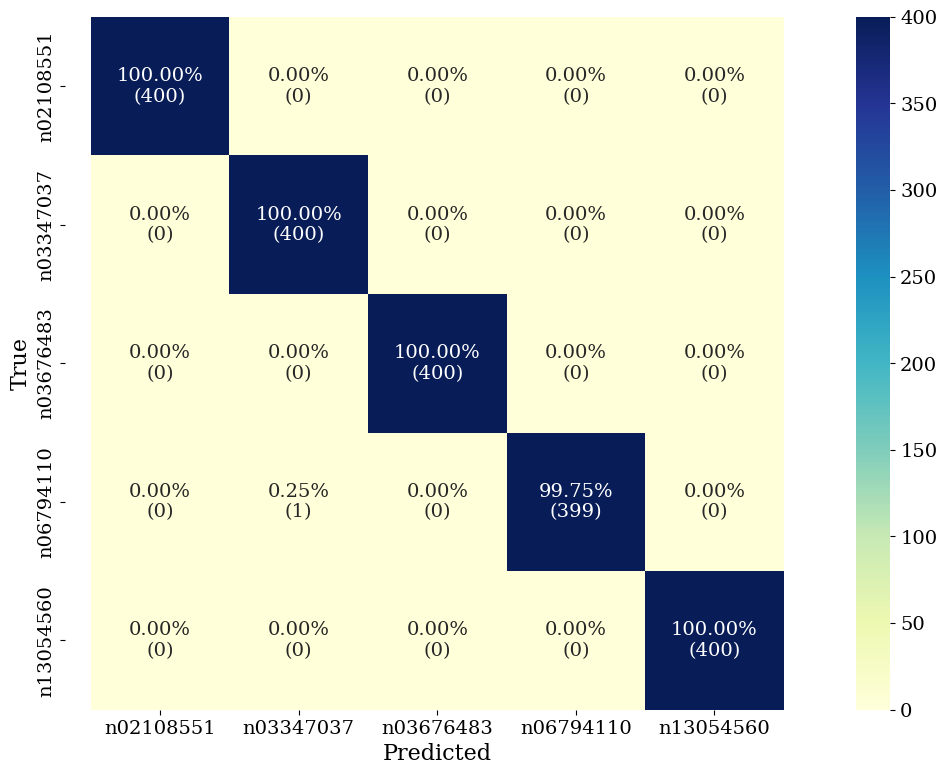

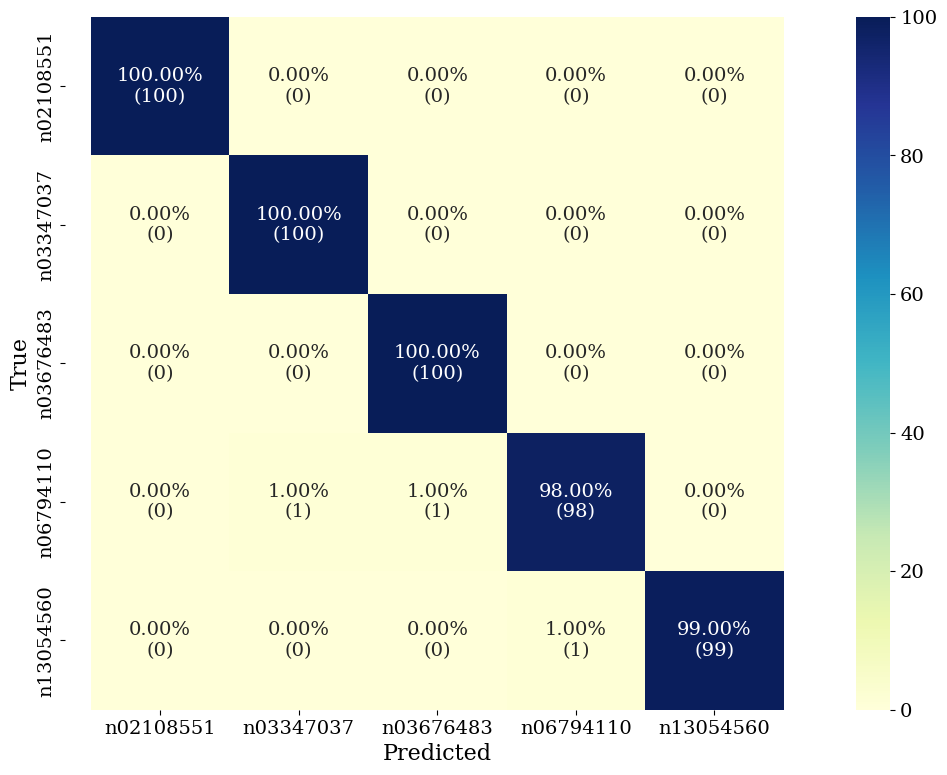

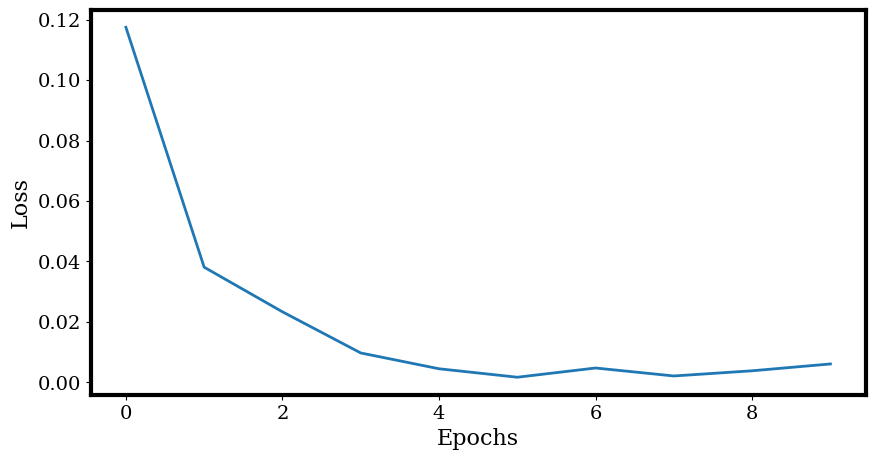

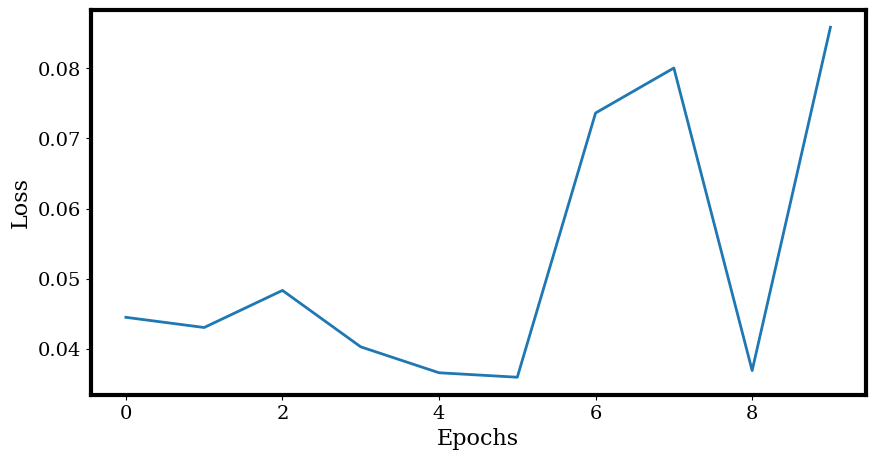

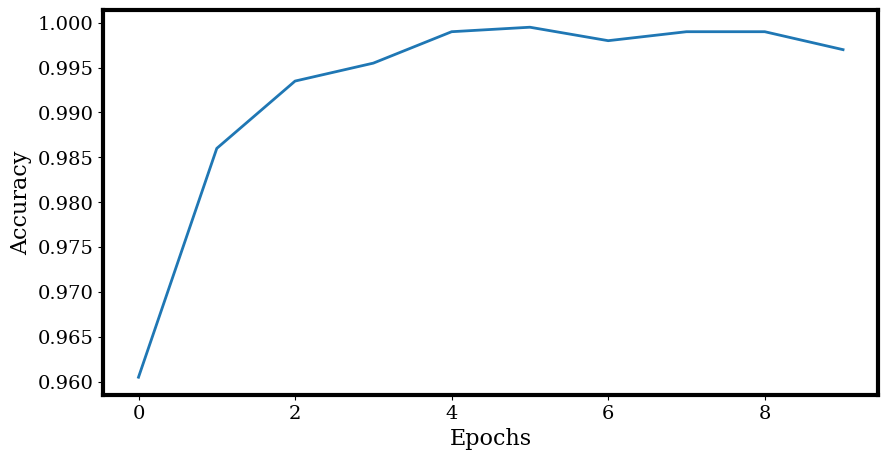

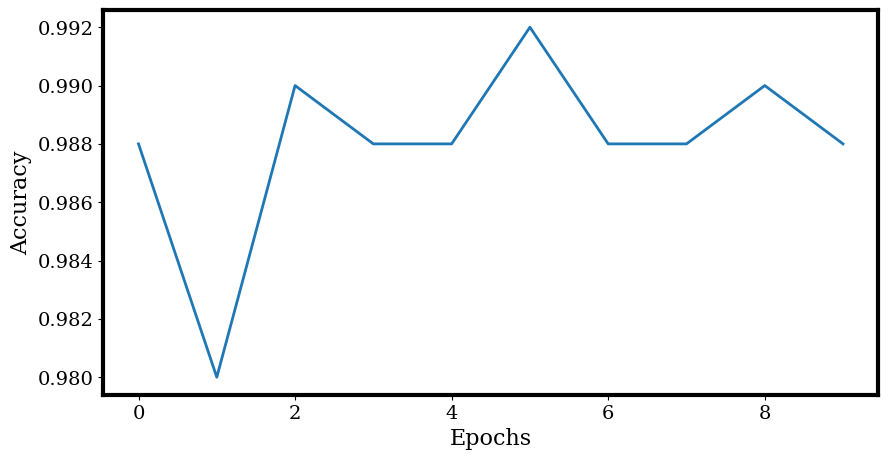

In [36]:
# Plot confusion matrix, losses, and accuracies
image_classification_vgg.plot_cm_train(train_loader)
image_classification_vgg.plot_cm_test(test_loader)
image_classification_vgg.plot_losses()
image_classification_vgg.plot_accuracies()

### (b) GoogLeNet as Deep CNN

In [37]:
# Load GoogLeNet
googlenet = models.googlenet(pretrained=True)
googlenet = googlenet.to(device)
googlenet.eval()

# Freeze the GoogLeNet parameters
for param in googlenet.parameters():
    param.requires_grad = False

# Print the GoogLeNet architecture
print(googlenet)

# MLFFNN architecture using GoogLeNet features
class MLFFNN_GoogLeNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLFFNN_GoogLeNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, num_classes)

    def forward(self, x):
        x = googlenet(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [38]:
dummy_input = torch.randn(1, 3, 224, 224).to(device)  # Example input (batch size 1)
googlenet_output = googlenet(dummy_input)
input_size = googlenet_output.view(googlenet_output.size(0), -1).shape[1]
print(input_size)

1000


In [39]:
# Initialize model, loss, and optimizer
hidden_size = 256
num_classes = len(train_dataset.classes) # = 5
model = MLFFNN_GoogLeNet(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [40]:
# Train and test the model
image_classification_googlenet = ImageClassification(model, criterion, optimizer, deep_cnn='googlenet')
image_classification_googlenet.train(train_loader, valid_loader, num_epochs=10)
image_classification_googlenet.test(test_loader)


Epoch 1/10: 100%|██████████| 63/63 [00:05<00:00, 10.87batch/s, Running Loss=0.129]


Epoch 1/10, Train Loss: 0.1287, Train Accuracy: 0.9760
Epoch 1/10, Valid Loss: 0.0390, Valid Accuracy: 0.9840


Epoch 2/10: 100%|██████████| 63/63 [00:05<00:00, 11.58batch/s, Running Loss=0.0201]


Epoch 2/10, Train Loss: 0.0201, Train Accuracy: 0.9915
Epoch 2/10, Valid Loss: 0.0108, Valid Accuracy: 0.9960


Epoch 3/10: 100%|██████████| 63/63 [00:05<00:00, 11.31batch/s, Running Loss=0.0034]


Epoch 3/10, Train Loss: 0.0034, Train Accuracy: 0.9995
Epoch 3/10, Valid Loss: 0.0159, Valid Accuracy: 0.9960


Epoch 4/10: 100%|██████████| 63/63 [00:05<00:00, 11.72batch/s, Running Loss=0.000898]


Epoch 4/10, Train Loss: 0.0009, Train Accuracy: 1.0000
Epoch 4/10, Valid Loss: 0.0099, Valid Accuracy: 0.9960
Test Loss: 0.0586, Test Accuracy: 0.9920


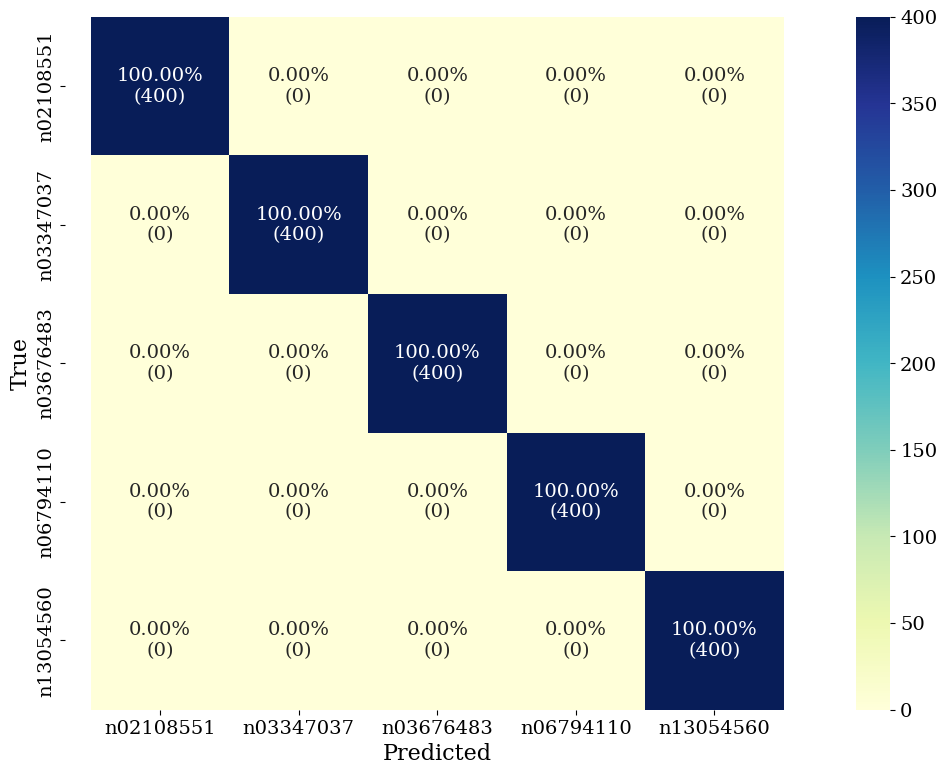

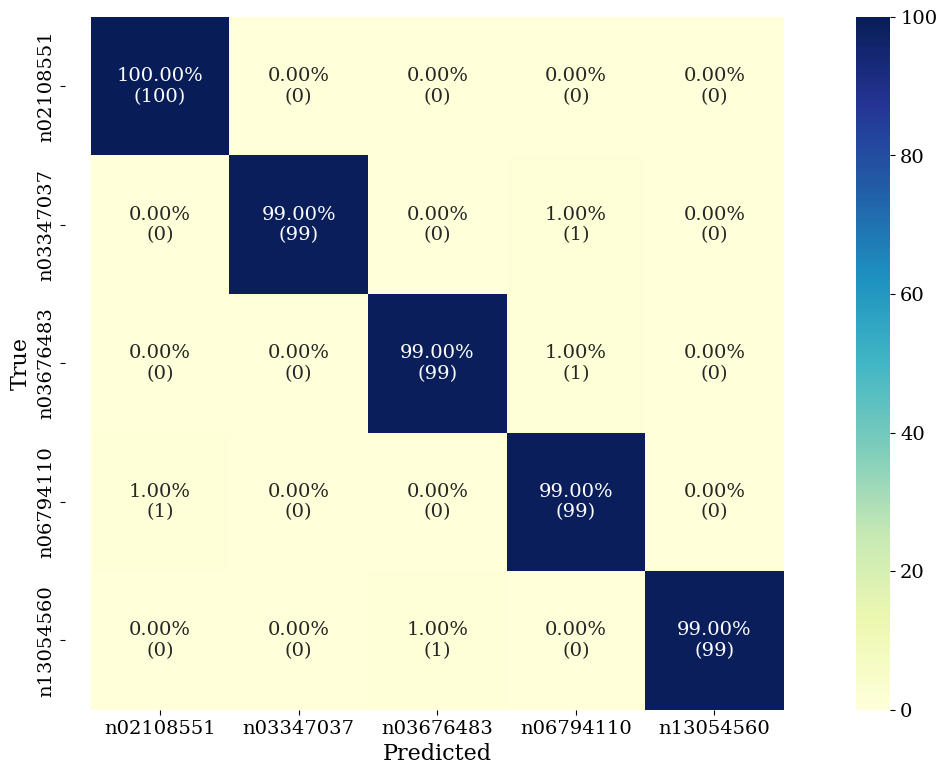

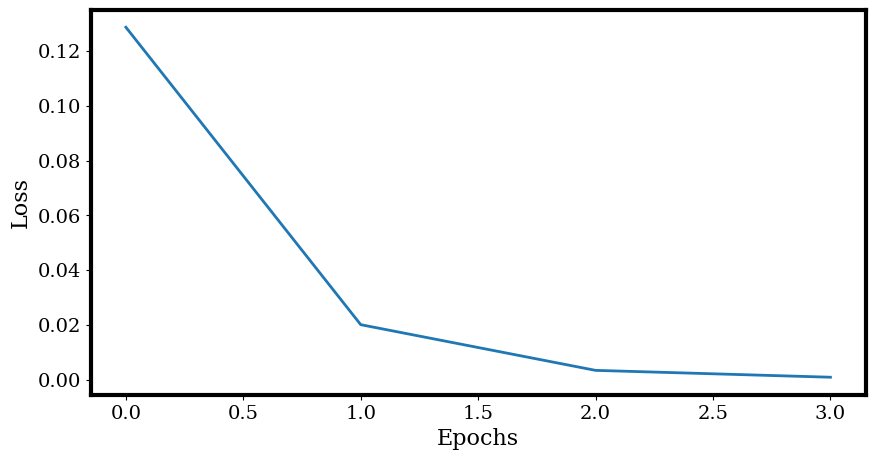

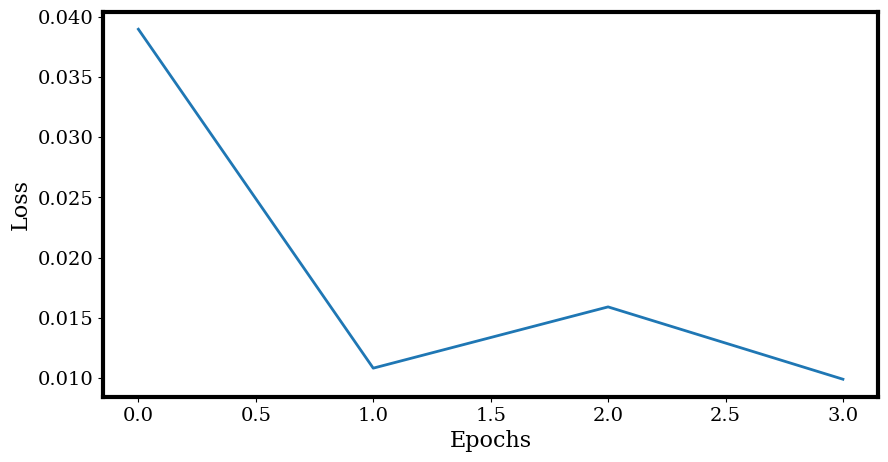

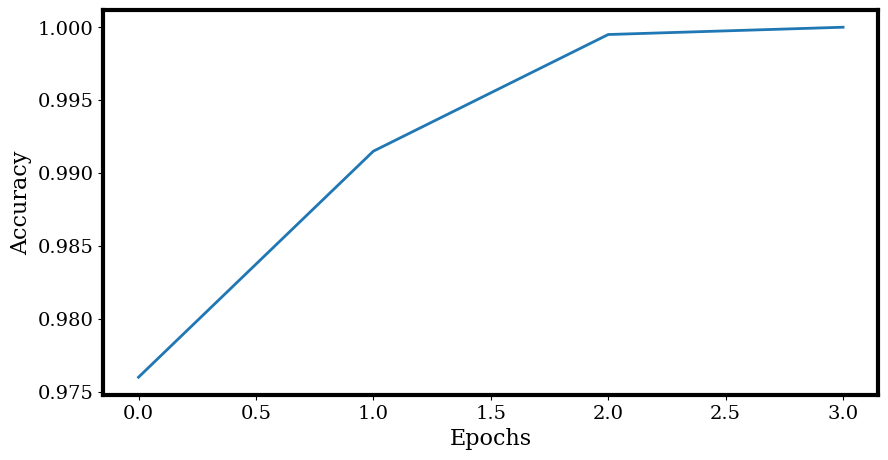

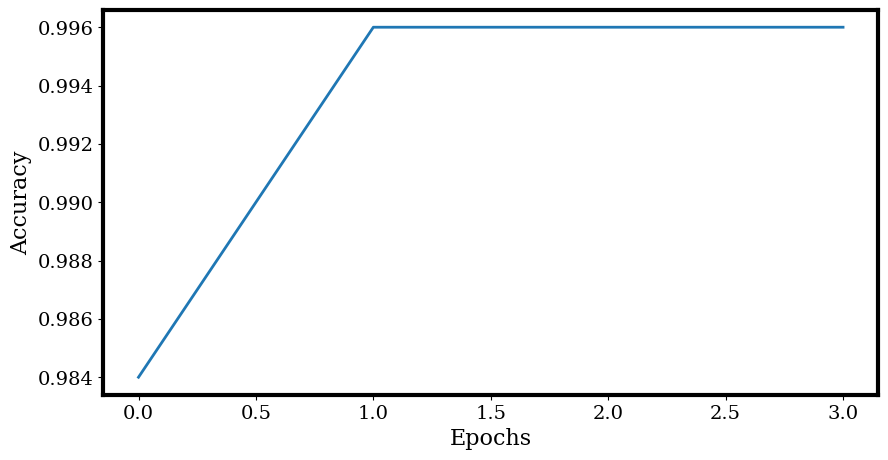

In [41]:
# Plot confusion matrix, losses, and accuracies
image_classification_googlenet.plot_cm_train(train_loader)
image_classification_googlenet.plot_cm_test(test_loader)
image_classification_googlenet.plot_losses()
image_classification_googlenet.plot_accuracies()


In [42]:
import zipfile
import os

# Define the path to the folder you want to zip
folder_path = '/content/plots/Q1'

# Define the path for the zip file
zip_path = '/content/plots/Q1.zip'

# Create a zip file of the folder
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), folder_path))

# Download the zip file
from google.colab import files
files.download(zip_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>